In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, matthews_corrcoef

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_public = pd.read_csv('survey_results_public.csv')

In [3]:
df_schema = pd.read_csv('survey_results_schema.csv')

The overall goal is to gain insight into the careers of professional developer. Of particular focus are the factors that influence a professional developer ‘s and . I adress the overall goal through 4 specific questions:

   Which values in columns are significance TGI for professional developer?

   Is professional developer taking the job for young people only？

   How well can we predict Profesional situaction?

   What are the most popular languages and tools among professional developer?

### Explode Data Analysis for Stack Overflow survey results data in 2017

In [4]:
df_public.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_public.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,51392.000000,42695.000000,40376.000000,20600.000000,36592.000000,12891.000000,2566.000000
mean,25696.500000,7.300574,6.957078,3.952282,8.429875,56298.480641,33142.220468
std,14835.736854,1.955444,2.167652,7.564722,1.390635,39880.905277,30162.988829
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12848.750000,6.000000,6.000000,1.000000,8.000000,26440.371839,4490.492484
50%,25696.500000,8.000000,7.000000,1.000000,9.000000,50000.000000,29364.263691
75%,38544.250000,9.000000,8.000000,4.000000,10.000000,80000.000000,50403.225806
max,51392.000000,10.000000,10.000000,40.000000,10.000000,197000.000000,187500.000000


In [98]:
def show_dtype(df='df'):
    d = {}
    for column in df.columns:
        d[column] = df[column].dtypes 
    column = pd.Series(d).to_frame()
    column.columns = ['type']
    return column

column = show_dtype(df_public)
column

,type
Respondent,int64
Professional,object
ProgramHobby,object
Country,object
University,object
...,...
QuestionsInteresting,object
QuestionsConfusing,object
InterestedAnswers,object
Salary,float64


In [39]:
df_schema[df_schema.Column == 'Professional']['Question'].values

array(['Which of the following best describes you?'], dtype=object)

In [10]:
df_proDevel = df_public[df_public.Professional == 'Professional developer']

In [11]:
df_proDevel.shape

(36131, 154)

In [12]:
df_proDevel = df_proDevel.dropna(subset=['YearsCodedJob'])

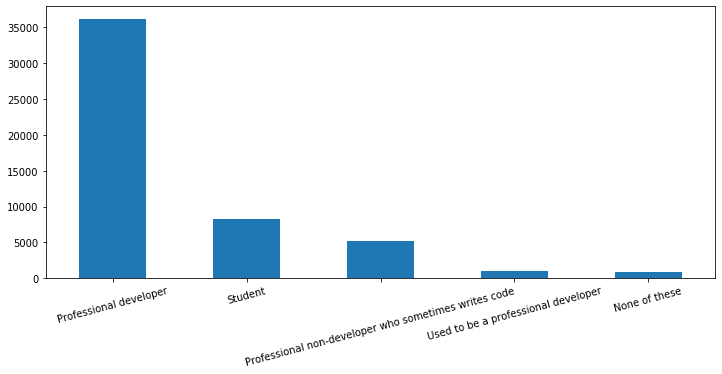

In [118]:
df_public['Professional'].value_counts().plot(kind='bar',figsize=(12,5));
plt.xticks(rotation=15);

In [13]:
df_proDevel['YearsCodedJobInt'] = df_proDevel['YearsCodedJob'].map(lambda x: int(x.split(" ")[0]) if not (x =='Less than a year') else 0)

1. Which values in columns are significance TGI  for professional developer?

In [104]:
def tgi(df='df',target_df='df', target_column='', sample_size=1000, min_tgi=1.28, top_ratio_num=1):
    '''
    Input:  df is all dataframe data for calculating TGI(target group index).
            target_df is target group dataframe .
            target_column is the column which the TGI in.
            sample_size Features' samples number less than sample_size in the data set will be dropped.
            min_tgi columns will be dropped which column's TGI below min_tgi
            top_ratio_num  is the number will being kept top ratio in the column.  

    Output: top_ratio_dict is a dictionary key being columns and value being top_ratio items in that column.  
    
    '''
    tgi = {}
    # Features' samples number less than sample_size in the data set will be dropped.
    sample_size = sample_size
    min_tgi = min_tgi
    top_ratio_num = 1
    
    for column in df.drop([target_column], axis=1).columns:
        # Features' samples number less than sample_size in the data set will be dropped.
        keep_len = (df[column].value_counts() > sample_size).sum()   
        # Target group index algorthm        
        top_ratio = ((target_df[column].value_counts().iloc[:keep_len] / target_df[column].shape[0])  \
                                   /(df[column].value_counts().iloc[:keep_len] / df[column].shape[0]))   \
                                   .sort_values(ascending=False).iloc[:top_ratio_num]
        
        # Skip the column being empty or all values being NAN.
        if np.isnan(top_ratio.values).sum() == len(top_ratio.values):
            continue
            
        filter_condition =  top_ratio.values[:1][0] > min_tgi # or np.isnan(top_five_ratio.values).any() 
                            
        if filter_condition:
            tgi[column] = top_ratio.index[0]
        
    tgi = pd.Series(tgi).to_frame()    
    tgi.columns = ['items']
    return tgi
         

In [105]:
tgi = tgi(df_public, df_proDevel, 'Professional')

In [106]:
tgi

,items
YearsCodedJob,8 to 9 years
DeveloperType,Web developer; Desktop applications developer
WebDeveloperType,Front-end Web developer
ResumePrompted,I received bad news about the future of my com...
LearnedHiring,An external recruiter or headhunter
Overpaid,Somewhat underpaid
EducationImportant,Not very important
HaveWorkedLanguage,C#; JavaScript; SQL
WantWorkFramework,React
HaveWorkedPlatform,Amazon Web Services (AWS)


2. Is professional developer taking the job for young people only？

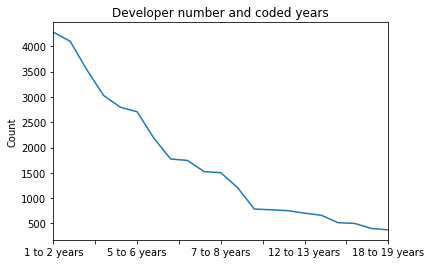

In [137]:
df_proDevel.YearsCodedJob.value_counts().plot(title='Developer number and coded years').set_ylabel('Count');

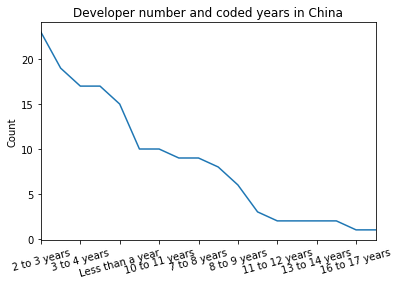

In [136]:
df_proDevel[df_proDevel.Country == 'China'].YearsCodedJob.value_counts().plot(title='Developer number and coded years in China').set_ylabel('Count');
plt.xticks(rotation=15);

About ten years (YearsCodedJob) porfessional developer number reducing become slow. 

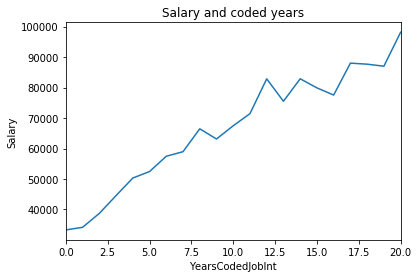

In [130]:
df_proDevel['Salary'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot(title='Salary and coded years').set_ylabel('Salary');

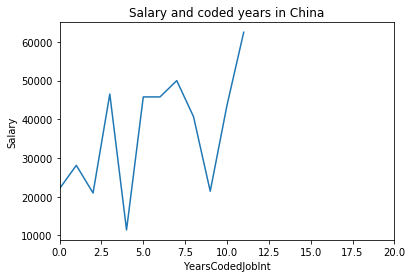

In [131]:
df_proDevel[df_proDevel.Country == 'China']['Salary'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot(title='Salary and coded years in China').set_ylabel('Salary');

More experimence, more money.

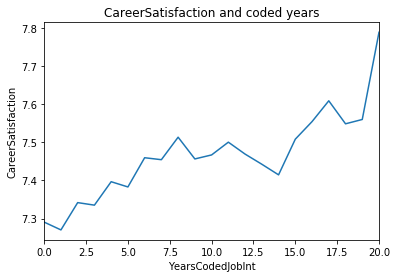

In [135]:
df_proDevel['CareerSatisfaction'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot(title='CareerSatisfaction and coded years').set_ylabel('CareerSatisfaction');

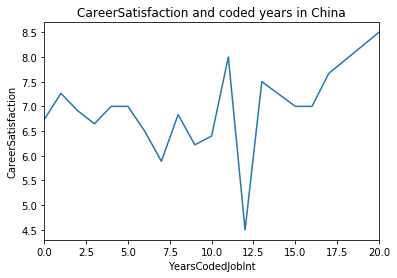

In [132]:
df_proDevel[df_proDevel.Country == 'China']['CareerSatisfaction'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot(title='CareerSatisfaction and coded years in China').set_ylabel('CareerSatisfaction');

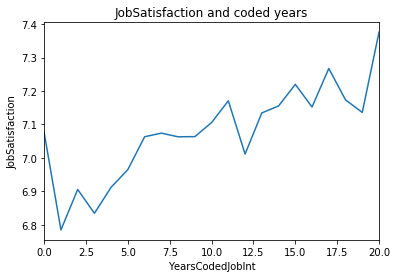

In [134]:
df_proDevel['JobSatisfaction'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot(title='JobSatisfaction and coded years').set_ylabel('JobSatisfaction');

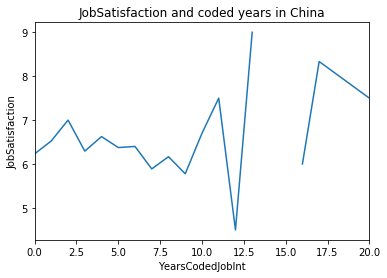

In [133]:
df_proDevel[df_proDevel.Country == 'China']['JobSatisfaction'].groupby(df_proDevel['YearsCodedJobInt']).mean().plot(title='JobSatisfaction and coded years in China').set_ylabel('JobSatisfaction');

Findings: In the world, salary \ career satisfaction\ job satisfaction is increasing with coded years . However, salary \ career satisfaction\ job satisfaction is not increasing with coded years in China.So, the answer is “No” in the world;The answer is “YES” in china.

3. How well can we predict Profesional situaction?

In [21]:
# Reference https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/

# class ColumnSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, columns):
#         self.columns = columns

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         assert isinstance(X, pd.DataFrame)

#         try:
#             return X[self.columns]
#         except KeyError:
#             cols_error = list(set(self.columns) - set(X.columns))
#             raise KeyError("The DataFrame does not include the columns: %s" % cols_error)


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [22]:
def build_model():
    preprocess_pipeline = make_pipeline(
        FeatureUnion(transformer_list=[
            #Fillnan for categorical(object) type data with most frequent and ordinal encode them.
            ("categorical_features", make_pipeline(
                TypeSelector("object"),
                SimpleImputer(strategy="most_frequent"),
                OrdinalEncoder()
            )),
            #Fillnan for numberic type data with mean and standard scale.
            ("numeric_features", make_pipeline(
                TypeSelector("number"),
                SimpleImputer(strategy="mean"),
                StandardScaler()
            ))
        ])
    )
    classifier_pipeline = make_pipeline(
        preprocess_pipeline,
        RandomForestClassifier()
    )
    
    # specify parameters for grid search
    parameters = {
        "randomforestclassifier__min_samples_leaf":(10, 100, 1000),
        "randomforestclassifier__n_estimators":[10, 100, 1000],
        "randomforestclassifier__warm_start":(True, False)

    }

    # create grid search object
    cv = GridSearchCV(classifier_pipeline, param_grid=parameters, cv=5, error_score='raise')
    
    return cv

In [23]:
def load_data():
    df = pd.read_csv('survey_results_public.csv')
    X = df.drop(['Professional'], axis=1)
    X = infrequence_to_nan(X, 20)
    y = df.Professional
    return X, y 

In [24]:
def infrequence_to_nan(df, thres=10):
    threshold = thres
    cat_columns = df.select_dtypes(include=['object']).columns
    for column in cat_columns:
        value_count = df.select_dtypes(include=['object'])[column].value_counts()
        to_move = value_count[value_count <= threshold]
        df[column].isin(to_move.index)
        df[column].mask(df[column].isin(to_move.index),inplace=True)
    return df

In [31]:
def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    corrcoef = matthews_corrcoef(y_test, y_pred)
    #importances = cv.best_estimator_.steps["pipeline"].feature_importances_

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Balanced_accuracy_score:\n", balanced_accuracy)
    print("\nMatthews_corrcoef:", corrcoef)
    print("\nBest Parameters:", cv.best_params_)
    

In [32]:
def main():
    X, y = load_data()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model = build_model()
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    display_results(model, y_test, y_pred)


main() 

{'steps': [('pipeline', Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_features',
                                                 Pipeline(memory=None,
                                                          steps=[('typeselector',
                                                                  TypeSelector(dtype='object')),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(add_indicator=False,
                                                                                copy=True,
                                                                                fill_value=None,
                                                                                missing_values=nan,
                                                                                str

4.What are the most popular languages among professional developer?

In [49]:
# Reference  https://www.kaggle.com/acassidy0982/a-look-into-the-career-of-data-science
flatten = lambda l: [item for sublist in l for item in sublist]  ## takes a list(list) -> list

def createDummies(column, _data):
    _data[column].fillna("", inplace=True)
    uniqueVals = set(flatten(list(map(lambda str: str.split("; "),
                                      list(_data[column].unique())))))
    uniqueVals.remove("")

    _dummies = pd.DataFrame(0, index=_data.index, columns=uniqueVals)
    for dummyCol in _dummies.columns:
        dummies = _data[column].map(lambda row: dummyCol in row)
        _dummies[dummyCol] = dummies

    return _dummies, uniqueVals

In [50]:
dummies, uniqueVals = createDummies('HaveWorkedLanguage', df_proDevel)

In [59]:
proDevel_lang = (dummies.sum(0).sort_values(ascending=False) / len(dummies) * 100.).to_frame()
proDevel_lang.columns = ["% Professional developer reported working with the language in 2017"]
proDevel_lang

,% Professional developer reported working with the language in 2017
Java,54.773116
JavaScript,44.510819
C,41.199019
SQL,36.492061
C#,24.276152
Python,22.773973
PHP,20.022572
C++,15.868229
R,9.828378
TypeScript,6.787049


In [57]:
all_dummies, uniqueVals = createDummies('HaveWorkedLanguage', df_public)

In [61]:
all_lang = (all_dummies.sum(0).sort_values(ascending=False) / len(all_dummies) * 100.).to_frame()
all_lang.columns = ["% All users reported working with the language in 2017"]
all_lang

,% All users reported working with the language in 2017
Java,54.773116
JavaScript,44.510819
C,41.199019
SQL,36.492061
C#,24.276152
Python,22.773973
PHP,20.022572
C++,15.868229
R,9.828378
TypeScript,6.787049


 Findings:Professional developer and all users use similar languages. Java\JavaScript\C\SQL\C#\Python\PHP more or less increasing, using more by Professional developer.